<a href="https://colab.research.google.com/github/Foxy1987/neuroGLM/blob/master/basis_function_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting stimulus temporal filters to vector space spanned by raised cosines
__Content creator:__ David Fox


This tutorial will explain how to import trial-based experimental data, and build appropriate features spaces to do regression analysis. The ultimate output of the regression is a set of weights on the coefficients that define a stimulus filter.

Here we will find filter weights by fitting filters to a low-dimensional space spanned by raised cosines. 
The time axis is scaled logarithmically so that the cosines are more narrow near time lag 0 but is more smooth at longer time scales. 

$$
B_i(t) = \frac{(\cos(\log[t + \Psi] + \phi_i) + 1}{2}
$$

for $t$ such that $\log(t + \Psi) \in [\phi_i - \pi, \phi_i + \pi]$ and 0 elsewhere ( so each basis vector looks like a single raised bump). The "bumps" are normalized so that they sum to 1 and orthogonalized. The resulting basis can represent fine temporal structure near 0 time lag and longer smooth structure at longer time lags. 

By fitting to a basis of raised cosines, we can simplify the fitting procedure. We ensure that the function is convex and can thus use scipy.optimize.minimize to compute estimates for the filter weights. In addition, by fitting to a basis functions, we can denoise by only specifying the temporal structure we care about.


# Import package and libraries

In [77]:
#@title Clone the github repository 
!git clone https://github.com/Foxy1987/neuroGLM
%cd neuroGLM

Cloning into 'neuroGLM'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 221 (delta 109), reused 132 (delta 51), pack-reused 0
Receiving objects: 100% (221/221), 4.05 MiB | 28.39 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/neuroGLM/neuroGLM/neuroGLM/neuroGLM


In [78]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [79]:
#@title import modules
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
from glmtools.make_xdsgn import Experiment, DesignSpec
from basisFactory.bases import Basis, RaisedCosine
from scipy.optimize import minimize
from glmtools.fit import x_proj
from utils import plot as nmaplt
import pickle

# Read in stimulus and behavior structure
The read function takes as arguments a matlab structure, whose fields are:
the behavior parameters you extracted from your experiment and 

1.   behavior parameters you extracted from your experiment
2.   Stimulus

each field is an $M$X$N$ where $M$ is the number of time points and $N$ is the number of trials.




In [80]:
#behavior_par = "vmoves"
behavior_par = "vymoves"
#behavior_par = "angvturns"

In [81]:
stim, response = io.load_behavior('../datasets/behavior/control_behavior.mat', 30., 55., behavior_par)

# Create an experiment object 
Now we will make an experiment object to hold response variable and to register the types of regressors in the experiment

In [82]:
expt = Experiment(0.02, 85, stim=stim, response=response)

# register continuous regressor
expt.registerContinuous('stim')

# Create a design specification object
This object holds all the information about how to construct the design matrix for each regressor. The function compile_design_matrix_from_trial_indices() stacks design matrices for a given regressor and for each trial on top of one another. 

In [83]:
trial_inds = list(range(response.shape[1]))
dspec = DesignSpec(expt, trial_inds)

# make a set of raised-cosine basis functions

In [84]:
# make a set of basis functions
Fs = 50
nkt = 2*Fs
cos_basis = RaisedCosine(100, 3, 1, 'stim')
cos_basis.makeNonlinearRaisedCosStim(expt.dtSp, [5, nkt/2-10], 1, nkt)

# register the regressor with the basis 
dspec.addRegressorContinuous(basis=cos_basis)

# Build the design matrix and view the contents
Now we use the information about each regressor included in the experiment and the number of trials to construct a design matrix

In [85]:
dm, X, y = dspec.compileDesignMatrixFromTrialIndices()

forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
convolving padded stimulus with 

# find weights in the new basis using scipy.optimize.minimize

In [86]:
prs = np.random.normal(0, .2, 4)
res = minimize(x_proj, prs, args=(X, y), options={'maxiter': 1000, 'disp': True})

theta = res['x']

Optimization terminated successfully.
         Current function value: 11.363969
         Iterations: 6
         Function evaluations: 66
         Gradient evaluations: 11


# convert back to the original basis to get nkt filter weights.
The filter and offset are returned in a dictionary

In [87]:
d = dm.get_regressor_from_output(theta[1:])

dc = theta[0]
k = d['stim'][1]

# Plot the stimulus filter

(-2.0, 0.1)

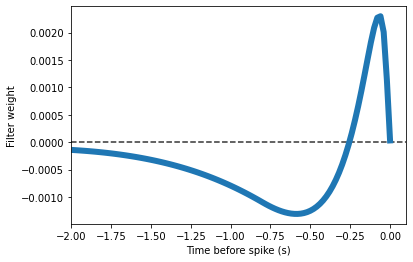

In [88]:
fig, ax1 = plt.subplots(1, 1)
nmaplt.plot_spike_filter(ax1, k, dspec.dt, linewidth=6)
ax1.set_xlim(-2, 0.1)